In [3]:
#!conda install -y -c conda-forge matplotlib

Solving environment: done

## Package Plan ##

  environment location: /home/ubuntu/anaconda3/envs/stacking

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotli-1.0.9               |       h7f98852_5          17 KB  conda-forge
    brotli-bin-1.0.9           |       h7f98852_5          19 KB  conda-forge
    ca-certificates-2021.10.8  |       ha878542_0         139 KB  conda-forge
    certifi-2021.10.8          |   py39hf3d152e_1         145 KB  conda-forge
    cycler-0.11.0              |     pyhd8ed1ab_0          10 KB  conda-forge
    dbus-1.13.6                |       he372182_0         602 KB  conda-forge
    expat-2.2.10               |       h9c3ff4c_0         164 KB  conda-forge
    fontconfig-2.13.1          |       h6c09931_0         250 KB
    fonttools-4.25.0           |     pyhd3eb1b0_0         632 KB
    freetype-2.11.0        

In [5]:
import os
import json
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from sklearn.feature_selection import mutual_info_classif

In [6]:
DATASETS = ["20ng", "acm", "reut", "webkb"]
N_CLASSES = [20, 11, 90, 7]
CLFS = ["bert", "kfr", "kpr", "ktmk", "ktr", "lfr", "lpr", "ltmk", "ltr", "sfr", "spr", "stmk", "str", "xfr", "xlnet", "xpr", "xtmk", "xtr"]
BASE_DIR = "/home/ubuntu/stacking_text_classification"
EXTRA_FEATURE_DIR = "extra_features_less_17"

In [7]:
def all_hit(y_true, preds):

    idx_list = []
    # Para cada documento.
    for idx in range(y_true.shape[0]):
        # Se todos acertaram.
        if np.all(y_true[idx] != preds[idx]):
            idx_list.append(idx)
    
    return idx_list

def get_some_hit(y_true, preds):

    idx_list = []
    # Para cada documento.
    for idx in range(y_true.shape[0]):
        
        result = y_true[idx] == preds[idx]
        counts = Counter(result)
        if counts.most_common()[0][1] < 17:
            idx_list.append(idx)
    
    return idx_list

In [9]:
dict_mi = {}
dict_mi_missed = {}
# Para cada dataset.
for DSET in DATASETS:
    mi_list = []
    mi_list_missed = []
    dict_mi[DSET] = {}
    dict_mi_missed[DSET] = {}
    # Para cada fold.
    for fold in tqdm(range(10)):
        probas = []
        preds = []
        y = None
        # Para cada classificador.
        for CLF in CLFS:
            load = np.load(f"{BASE_DIR}/data/meta_layer_input/{DSET}/10_folds/{CLF}/{fold}/test.npz", allow_pickle=True)
            prob_fold = load["X_test"]
            if y is None:
                y = load["y_test"]
            probas.append(prob_fold)
            # Identificando as predições dos classificadores.
            preds.append(prob_fold.argmax(axis=1))
        
        probas = np.hstack(probas)
        preds = np.vstack(preds).T

        # Lendo atributos extra.
        extra_feats = pd.read_pickle(f"{BASE_DIR}/data/{EXTRA_FEATURE_DIR}/fold_{fold}/{DSET}/test.csv")
        extra_feats.fillna(0,inplace=True)
        
        #mi = mutual_info_classif(meta_feats, y)
        #mi_list.append(mi)

        #idx_missed = all_hit(y, preds)
        
        idx_missed = get_some_hit(y, preds)

        #meta_feats_missed = np.take(meta_feats, idx_missed, axis=0)
        probas_missed = np.take(probas, idx_missed, axis=0)
        meta_feats = np.hstack([probas_missed, extra_feats.values])
        y_missed = np.take(y, idx_missed)
        mi_missed = mutual_info_classif(meta_feats, y_missed)
        mi_list_missed.append(mi_missed)

    #dict_mi[DSET]["mean_mi"] = np.mean(mi_list, axis=0).tolist()
    #dict_mi[DSET]["std_mi"] = np.std(mi_list, axis=0).tolist()

    dict_mi_missed[DSET]["mean_mi"] = np.mean(mi_list_missed, axis=0).tolist()
    dict_mi_missed[DSET]["std_mi"] = np.std(mi_list_missed, axis=0).tolist()

  0%|          | 0/10 [00:00<?, ?it/s]


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 588 and the array at index 1 has size 624

In [32]:
len(dict_mi_missed["20ng"]["mean_mi"])

363

In [ ]:
with open("outputs/mi.json", 'w') as fd:
    json.dump(dict_mi, fd)

In [21]:
with open("outputs/mi.json", "r") as fd:
    dict_mi = json.load(fd)

In [23]:
def indice_to_clf(n_classes, clfs):

    idx_to_clf = {}
    global_idx = 0
    for clf in clfs:
        for idx in range(n_classes):
            idx_to_clf[global_idx] = clf
            global_idx += 1
    
    idx_to_clf[global_idx] = "IDF"
    global_idx += 1
    idx_to_clf[global_idx] = "Chi2"
    global_idx += 1
    idx_to_clf[global_idx] = "DocLen"
    return idx_to_clf

idx_to_clf = {}
ranking_feats = {}
ranking_feats_missed = {}
for DSET, N in zip(DATASETS, N_CLASSES):
    
    minfo = np.array(dict_mi[DSET]["mean_mi"])
    ranking_feats[DSET] = (-minfo).argsort()

    minfo_missed = np.array(dict_mi_missed[DSET]["mean_mi"])
    ranking_feats_missed[DSET] = (-minfo_missed).argsort()
    
    idx_to_clf[DSET] = indice_to_clf(N, CLFS)

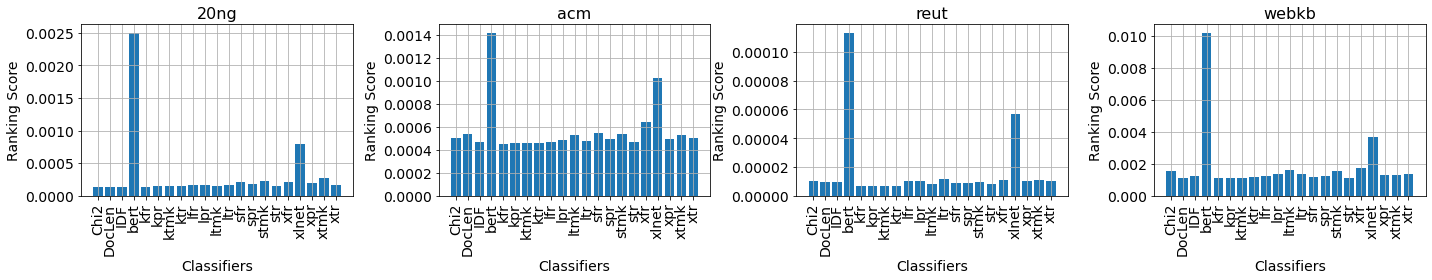

In [24]:
plt.figure(figsize=(20,4))
clf_scores = {}
results = []
for plot_idx, (DSET, N) in enumerate(zip(DATASETS, N_CLASSES)):
    clf_scores[DSET] = {}
    for count, idx in enumerate(ranking_feats[DSET]):
        c = idx_to_clf[DSET][idx]
        if c not in clf_scores:
            clf_scores[DSET][c] = 0
        deno = 1 + count
        clf_scores[DSET][c] += (1 / deno) / N
        if c in ["DocLen", "IDF", "Chi2"]:
            #if c == "Extra Feats":
            #print(f"posição: {count} de {ranking_feats[DSET].shape[0]}, score: {1 / deno}")
            results.append([DSET, ranking_feats[DSET].shape[0], c, count, 1 / deno])

    keys = list(clf_scores[DSET].keys())
    keys.sort()
    y = [ clf_scores[DSET][key] for key in keys ]
    x = np.arange(len(y))
    plt.subplot(1,4, plot_idx+1)
    plt.bar(x, y, width=0.8)
    plt.xticks(ticks=x, labels=keys, rotation=90, fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Classifiers", fontsize=14)
    plt.ylabel("Ranking Score", fontsize=14)
    plt.title(DSET, fontsize=16)
    plt.grid()
plt.tight_layout(w_pad=0.3)
plt.savefig("/home/ubuntu/stacking_text_classification/notebooks/analysis/charts/mi_clfs.pdf")

In [155]:
ranking_feats["20ng"][:10], dict_mi["20ng"]["mean_mi"][8]

(array([ 8, 15,  1, 14,  4, 17, 16,  7, 13, 18]), 0.9761176773160589)

In [25]:
def plot_mi(ranking_feats, dict_mi, idx_to_clf, format_chart=True, label=None, alpha=1, color=None):
    clf_scores = {}
    results = []
    # Para cada base de dados.
    for plot_idx, (DSET, N) in enumerate(zip(DATASETS, N_CLASSES)):
        clf_scores[DSET] = {}
        # Para cada atributo.
        for count, idx in enumerate(ranking_feats[DSET]):
            # Recuperando classificador dono do atributo.
            c = idx_to_clf[DSET][idx]
            if c not in clf_scores:
                clf_scores[DSET][c] = 0
            # Se c for um meta atributo.
            if c in ["DocLen", "IDF", "Chi2"]:
                clf_scores[DSET][c] += dict_mi[DSET]["mean_mi"][idx]
                #if c == "Extra Feats":
                #print(f"posição: {count} de {ranking_feats[DSET].shape[0]}, score: {1 / deno}")
                results.append([DSET, ranking_feats[DSET].shape[0], c, count, dict_mi[DSET]["mean_mi"][ranking_feats[DSET][idx]]])
            else:
                clf_scores[DSET][c] += dict_mi[DSET]["mean_mi"][idx] #/ N

        keys = list(clf_scores[DSET].keys())
        keys.sort()
        y = [ clf_scores[DSET][key] for key in keys ]

        x = np.arange(len(y))
        plt.subplot(1,4, plot_idx+1)
        plt.bar(x, y, width=0.8, alpha=alpha, label=label, color=color)
        if format_chart:
            plt.xticks(ticks=x, labels=keys, rotation=90, fontsize=14)
            plt.yticks(fontsize=14)
            plt.xlabel("Classifiers", fontsize=14)
            plt.ylabel("Ranking Score", fontsize=14)
            plt.title(DSET, fontsize=16)
            plt.grid()
            plt.legend()
    
    return results

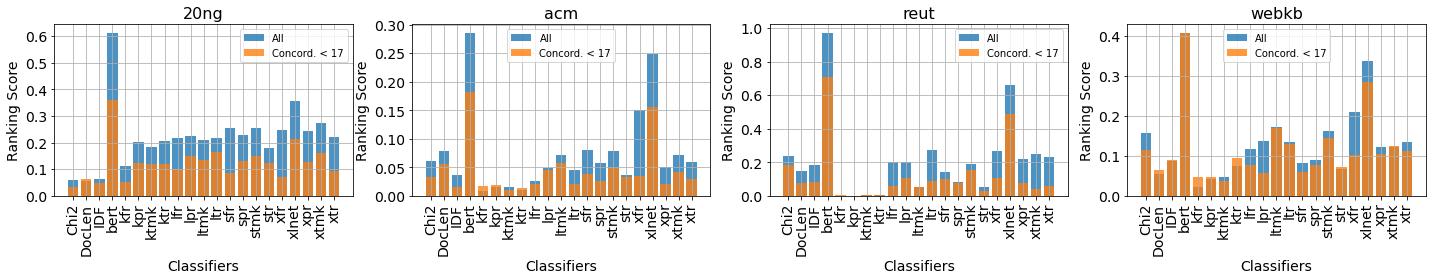

In [27]:
plt.figure(figsize=(20,4))
results = plot_mi(ranking_feats, dict_mi, idx_to_clf, format_chart=False, label="All", alpha=0.8, color="tab:blue")
results_missed = plot_mi(ranking_feats_missed, dict_mi_missed, idx_to_clf, label="Concord. < 17", alpha=0.8, color="tab:orange")
plt.tight_layout(w_pad=0.3)
plt.savefig("/home/ubuntu/stacking_text_classification/notebooks/analysis/charts/mi_only_missed.pdf")

In [168]:
tb = pd.DataFrame(results, columns=["Dataset", "Total Features", "Feature", "Ranking", "Score"])
tb

,Dataset,Total Features,Feature,Ranking,Score
0,20ng,363,IDF,360,0.062793
1,20ng,363,Chi2,361,0.058391
2,20ng,363,DocLen,362,0.056889
3,acm,201,DocLen,167,0.008370
4,acm,201,Chi2,180,0.009474
5,acm,201,IDF,193,0.010813
6,reut,1623,Chi2,1046,0.001457
7,reut,1623,IDF,1145,0.001737
8,reut,1623,DocLen,1201,0.000888
9,webkb,129,Chi2,92,0.040911


In [169]:
tb = pd.DataFrame(results_missed, columns=["Dataset", "Total Features", "Feature", "Ranking", "Score"])
tb

,Dataset,Total Features,Feature,Ranking,Score
0,20ng,363,IDF,3,1.565414e-15
1,20ng,363,DocLen,13,1.565414e-15
2,20ng,363,Chi2,27,1.565414e-15
3,acm,201,IDF,1,5.662137e-16
4,acm,201,Chi2,8,5.662137e-16
5,acm,201,DocLen,16,5.662137e-16
6,reut,1623,Chi2,3,1.898668e-04
7,reut,1623,DocLen,17,7.844011e-05
8,reut,1623,IDF,92,2.347254e-04
9,webkb,129,DocLen,1,3.774758e-16


In [ ]:
pd.DataFrame(clf_scores)

,20ng,acm,reut,webkb
bert,0.002500,0.001420,0.000113,0.010204
xlnet,0.000794,0.001021,0.000057,0.003663
sfr,0.000216,0.000548,0.000009,0.001181
lfr,0.000161,0.000464,0.000010,0.001242
xtmk,0.000267,0.000525,0.000011,0.001276
kpr,0.000152,0.000459,0.000007,0.001116
xpr,0.000198,0.000491,0.000010,0.001287
stmk,0.000227,0.000538,0.000010,0.001553
spr,0.000177,0.000497,0.000009,0.001221
lpr,0.000169,0.000486,0.000010,0.001374


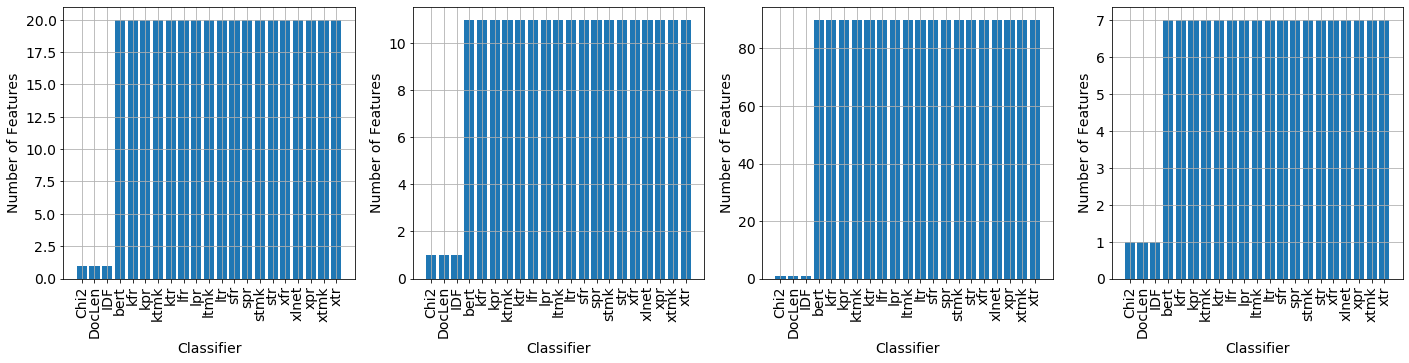

In [ ]:
_ = plt.figure(figsize=(24,5))
for plot_idx, DSET in enumerate(DATASETS):
    
    counts = Counter([ idx_to_clf[DSET][idx] for idx in ranking_feats[DSET] ])
    top_clfs = list(counts.keys())
    top_clfs.sort()
    y = [ counts[c] for c in top_clfs ]
    x = np.arange(len(y))
    plt.subplot(1, 4, plot_idx + 1)
    plt.bar(x, y)
    plt.xticks(ticks=x, labels=top_clfs, rotation=90, fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    plt.xlabel("Classifier", fontsize=14)
    plt.ylabel("Number of Features", fontsize=14)
    
